In [ ]:
!pip install pfhedge

### Last time

In [ ]:
import pfhedge
import torch
from torch.utils.data import Dataset, DataLoader

from pfhedge.instruments import BrownianStock
from pfhedge.instruments import EuropeanOption
from pfhedge.nn import MultiLayerPerceptron

stock = BrownianStock(cost=0.0001)
derivative = EuropeanOption(stock, strike=1.0)
m = MultiLayerPerceptron(3)

torch.manual_seed(42)

derivative.simulate(2000)
lm = derivative.moneyness()
t = derivative.time_to_maturity()
v = derivative.ul().volatility

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.stack(data, dim=-1)

    def __len__(self):
        return self.data.size(1)

    def __getitem__(self, index):
        return self.data[:, index, :].unsqueeze(1)

ds = MyDataset([lm, t, v])

In [ ]:
m

MultiLayerPerceptron(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=1, bias=True)
  (9): Identity()
)

In [ ]:
class MLP(torch.nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
mm = MLP(m)
mm

MLP(
  (model): MultiLayerPerceptron(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Identity()
  )
)

In [ ]:
mm(torch.randn(2,3))

tensor([[0.1421],
        [0.1332]], grad_fn=<AddmmBackward0>)

In [ ]:
def compute_hedge(model, ds):
    outputs = []
    for i in ds:
        outputs.append(model(i))

    return torch.cat(outputs, dim=-1)

In [ ]:
compute_hedge(mm, ds)

tensor([[[0.1424, 0.1424, 0.1423,  ..., 0.1427, 0.1427, 0.1427]],

        [[0.1424, 0.1424, 0.1423,  ..., 0.1423, 0.1423, 0.1423]],

        [[0.1424, 0.1424, 0.1425,  ..., 0.1427, 0.1427, 0.1427]],

        ...,

        [[0.1424, 0.1424, 0.1424,  ..., 0.1422, 0.1422, 0.1422]],

        [[0.1424, 0.1424, 0.1424,  ..., 0.1424, 0.1423, 0.1423]],

        [[0.1424, 0.1424, 0.1425,  ..., 0.1426, 0.1427, 0.1426]]],
       grad_fn=<CatBackward0>)

In [ ]:
def compute_portfolio(mm, ds, derivative):

    spot = torch.stack([derivative.ul().spot], dim=1)
    unit = compute_hedge(mm, ds)

    return pfhedge.nn.functional.pl(spot, unit)

In [ ]:
compute_portfolio(mm, ds, derivative)

tensor([-0.0063,  0.0101, -0.0064,  ...,  0.0124,  0.0101, -0.0027],
       grad_fn=<SumBackward1>)

In [ ]:
def compute_portfolio_2(mm, ds, derivative):

    spot = torch.stack([derivative.ul().spot], dim=1)
    unit = compute_hedge(mm, ds)

    return pfhedge.nn.functional.pl(spot, unit, payoff=derivative.payoff())

In [ ]:
compute_portfolio_2(mm, ds, derivative)

tensor([-0.0063, -0.0606, -0.0064,  ..., -0.0748, -0.0609, -0.0027],
       grad_fn=<SubBackward0>)

In [ ]:
# def fit(mm, ds, derivative):

#     optimizer = torch.optim.Adam(mm.parameters())

#     for i in range(1000):
#         optimizer.zero_grad()
#         cash = compute_portfolio_2(mm, ds, derivative)
#         loss = pfhedge.nn.functional.entropic_risk_measure(cash)
#         loss.backward()
#         optimizer.step()

#         if i % 100 == 0:
#             print(loss)



In [ ]:
# fit(mm, ds, derivative)

# prev_hedge

In [ ]:
class MLP(torch.nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.register_buffer("prev_hedge", None)

    def forward(self, x):
        if self.prev_hedge is None:
            self.register_buffer("prev_hedge", torch.zeros(x.size(0), x.size(1), 1))

        new_x = torch.cat([x, self.prev_hedge], dim=-1)

        out = self.model(new_x)

        self.prev_hedge = out.detach()

        return out

In [ ]:
mmp = MLP(MultiLayerPerceptron(4))

In [ ]:
mmp

MLP(
  (model): MultiLayerPerceptron(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Identity()
  )
)

In [ ]:
def fit(model, ds, derivative):

    optimizer = torch.optim.Adam(model.parameters())

    for i in range(1000):
        optimizer.zero_grad()
        cash = compute_portfolio_2(model, ds, derivative)
        # loss = torch.mean(cash*cash)
        loss = pfhedge.nn.functional.expected_shortfall(cash, 0.5)
        # loss = pfhedge.nn.functional.entropic_risk_measure(cash)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(loss)

In [ ]:
fit(mmp, ds, derivative)

tensor(0.0459, grad_fn=<NegBackward0>)
tensor(0.0359, grad_fn=<NegBackward0>)
tensor(0.0345, grad_fn=<NegBackward0>)
tensor(0.0058, grad_fn=<NegBackward0>)
tensor(-0.0085, grad_fn=<NegBackward0>)
tensor(-0.0217, grad_fn=<NegBackward0>)
tensor(-0.0482, grad_fn=<NegBackward0>)
tensor(0.7062, grad_fn=<NegBackward0>)
tensor(0.0360, grad_fn=<NegBackward0>)
tensor(0.0358, grad_fn=<NegBackward0>)


In [ ]:
temp = compute_hedge(mmp, ds).squeeze(1).detach().numpy()

In [ ]:
temp2 = compute_portfolio_2(mmp, ds, derivative).detach().numpy()

In [ ]:
import matplotlib.pyplot as plt

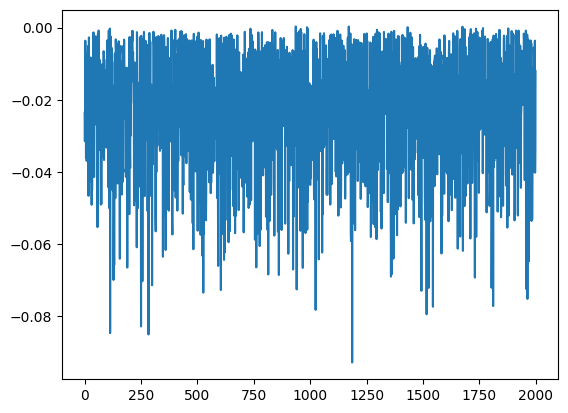

In [ ]:
plt.plot(temp2.T)
#plt.ylim(-0.1, 0.1)
plt.show()

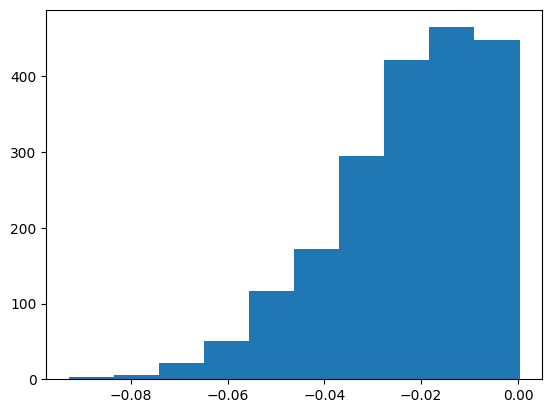

In [ ]:
plt.hist(temp2.T)
plt.show()

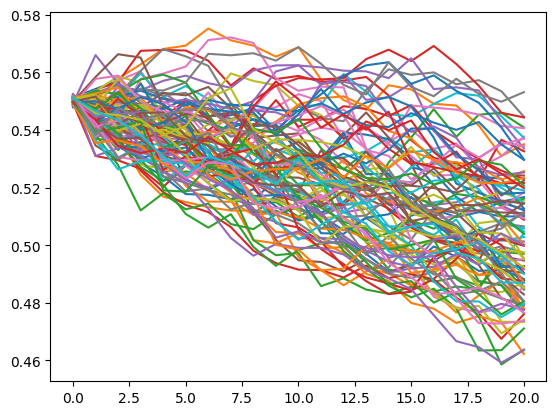

In [ ]:
plt.plot(temp[0:100].T)
plt.show()